In [1]:
!pip3 install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip3 install findspark

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.3.1-bin-hadoop3')
findspark.find()

'/home/ubuntu/spark-3.3.1-bin-hadoop3'

In [2]:
from pyspark.sql import SparkSession

# The entry point into all functionality in Spark is the SparkSession class.
spark = (SparkSession
	.builder
	.appName("DS5110/CS5501: my awesome Spark program - balanced att1")
	.master("spark://172.31.8.146:7077")
	.config("spark.executor.memory", "1024M")
	.getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/29 20:17:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import col, count, desc, rand, when

from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import functions as F


## specify the data type of each column 

In [5]:
# Define the schema for the DataFrame
schema = StructType([
    StructField('_c0', IntegerType()),
    StructField('Flow ID', StringType()),
    StructField('Src IP', StringType()),
    StructField('Src Port', IntegerType()),
    StructField('Dst IP', StringType()),
    StructField('Dst Port', IntegerType()),
    StructField('Protocol', IntegerType()),
    StructField('Timestamp', StringType()),
    StructField('Flow Duration', IntegerType()),
    StructField('Tot Fwd Pkts', IntegerType()),
    StructField('Tot Bwd Pkts', IntegerType()),
    StructField('TotLen Fwd Pkts', FloatType()),
    StructField('TotLen Bwd Pkts', FloatType()),
    StructField('Fwd Pkt Len Max', FloatType()),
    StructField('Fwd Pkt Len Min', FloatType()),
    StructField('Fwd Pkt Len Mean', FloatType()),
    StructField('Fwd Pkt Len Std', FloatType()),
    StructField('Bwd Pkt Len Max', FloatType()),
    StructField('Bwd Pkt Len Min', FloatType()),
    StructField('Bwd Pkt Len Mean', FloatType()),
    StructField('Bwd Pkt Len Std', FloatType()),
    StructField('Flow Byts/s', FloatType()),
    StructField('Flow Pkts/s', FloatType()),
    StructField('Flow IAT Mean', FloatType()),
    StructField('Flow IAT Std', FloatType()),
    StructField('Flow IAT Max', FloatType()),
    StructField('Flow IAT Min', FloatType()),
    StructField('Fwd IAT Tot', FloatType()),
    StructField('Fwd IAT Mean', FloatType()),
    StructField('Fwd IAT Std', FloatType()),
    StructField('Fwd IAT Max', FloatType()),
    StructField('Fwd IAT Min', FloatType()),
    StructField('Bwd IAT Tot', FloatType()),
    StructField('Bwd IAT Mean', FloatType()),
    StructField('Bwd IAT Std', FloatType()),
    StructField('Bwd IAT Max', FloatType()),
    StructField('Bwd IAT Min', FloatType()),
    StructField('Fwd PSH Flags', IntegerType()),
    StructField('Bwd PSH Flags', IntegerType()),
    StructField('Fwd URG Flags', IntegerType()),
    StructField('Bwd URG Flags', IntegerType()),
    StructField('Fwd Header Len', IntegerType()),
    StructField('Bwd Header Len', IntegerType()),
    StructField('Fwd Pkts/s', FloatType()),
    StructField('Bwd Pkts/s', FloatType()),
    StructField('Pkt Len Min', FloatType()),
    StructField('Pkt Len Max', FloatType()),
    StructField('Pkt Len Mean', FloatType()),
    StructField('Pkt Len Std', FloatType()),
    StructField('Pkt Len Var', FloatType()),
    StructField('FIN Flag Cnt', IntegerType()),
    StructField('SYN Flag Cnt', IntegerType()),
    StructField('RST Flag Cnt', IntegerType()),
    StructField('PSH Flag Cnt', IntegerType()),
    StructField('ACK Flag Cnt', IntegerType()),
    StructField('URG Flag Cnt', IntegerType()),
    StructField('CWE Flag Count', IntegerType()),
    StructField('ECE Flag Cnt', IntegerType()),
    StructField('Down/Up Ratio', FloatType()),
    StructField('Pkt Size Avg', FloatType()),
    StructField('Fwd Seg Size Avg', FloatType()),
    StructField('Bwd Seg Size Avg', FloatType()),
    StructField('Fwd Byts/b Avg', IntegerType()),
    StructField('Fwd Pkts/b Avg', IntegerType()),
    StructField('Fwd Blk Rate Avg', IntegerType()),
    StructField('Bwd Byts/b Avg', IntegerType()),
    StructField('Bwd Pkts/b Avg', IntegerType()),
    StructField('Bwd Blk Rate Avg', IntegerType()),
    StructField('Subflow Fwd Pkts', IntegerType()),
    StructField('Subflow Fwd Byts', IntegerType()),
    StructField('Subflow Bwd Pkts', IntegerType()),
    StructField('Subflow Bwd Byts', IntegerType()),
    StructField('Init Fwd Win Byts', IntegerType()),
    StructField('Init Bwd Win Byts', IntegerType()),
    StructField('Fwd Act Data Pkts', IntegerType()),
    StructField('Fwd Seg Size Min', IntegerType()),
    StructField('Active Mean', FloatType()),
    StructField('Active Std', FloatType()),
    StructField('Active Max', FloatType()),
    StructField('Active Min', FloatType()),
    StructField('Idle Mean', FloatType()),
    StructField('Idle Std', FloatType()),
    StructField('Idle Max', FloatType()),
    StructField('Idle Min', FloatType()),
    StructField('Label', StringType())
])

## Read the balanced dataset info dataframe

In [6]:
df = spark.read.csv("hdfs://172.31.8.146:9000/final_dataset.csv", header=True)

In [10]:
# without schema
df.head(1)

24/04/24 00:19:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(_c0='624', Flow ID='192.168.4.118-203.73.24.75-4504-80-6', Src IP='192.168.4.118', Src Port='4504', Dst IP='203.73.24.75', Dst Port='80', Protocol='6', Timestamp='12/06/2010 08:34:32 AM', Flow Duration='3974862', Tot Fwd Pkts='29', Tot Bwd Pkts='44', TotLen Fwd Pkts='86.0', TotLen Bwd Pkts='59811.0', Fwd Pkt Len Max='86.0', Fwd Pkt Len Min='0.0', Fwd Pkt Len Mean='2.9655172413793096', Fwd Pkt Len Std='15.969799083226464', Bwd Pkt Len Max='1460.0', Bwd Pkt Len Min='0.0', Bwd Pkt Len Mean='1359.3409090909086', Bwd Pkt Len Std='372.02718975289076', Flow Byts/s='15068.950821437324', Flow Pkts/s='18.365417466065487', Flow IAT Mean='55206.41666666666', Flow IAT Std='195478.31665363663', Flow IAT Max='1566821.0', Flow IAT Min='167.0', Fwd IAT Tot='3735347.0', Fwd IAT Mean='133405.25', Fwd IAT Std='341775.6887123293', Fwd IAT Max='1805015.0', Fwd IAT Min='167.0', Bwd IAT Tot='3974862.0', Bwd IAT Mean='92438.65116279072', Bwd IAT Std='248174.8205743075', Bwd IAT Max='1566821.0', Bwd IAT Mi

In [7]:
df = spark.read.csv("hdfs://172.31.8.146:9000/final_dataset.csv", schema=schema, header=True)

In [12]:
# with schema
df.head(1)

[Row(_c0=624, Flow ID='192.168.4.118-203.73.24.75-4504-80-6', Src IP='192.168.4.118', Src Port=4504, Dst IP='203.73.24.75', Dst Port=80, Protocol=6, Timestamp='12/06/2010 08:34:32 AM', Flow Duration=3974862, Tot Fwd Pkts=29, Tot Bwd Pkts=44, TotLen Fwd Pkts=86.0, TotLen Bwd Pkts=59811.0, Fwd Pkt Len Max=86.0, Fwd Pkt Len Min=0.0, Fwd Pkt Len Mean=2.965517282485962, Fwd Pkt Len Std=15.969799041748047, Bwd Pkt Len Max=1460.0, Bwd Pkt Len Min=0.0, Bwd Pkt Len Mean=1359.3409423828125, Bwd Pkt Len Std=372.0271911621094, Flow Byts/s=15068.951171875, Flow Pkts/s=18.36541748046875, Flow IAT Mean=55206.41796875, Flow IAT Std=195478.3125, Flow IAT Max=1566821.0, Flow IAT Min=167.0, Fwd IAT Tot=3735347.0, Fwd IAT Mean=133405.25, Fwd IAT Std=341775.6875, Fwd IAT Max=1805015.0, Fwd IAT Min=167.0, Bwd IAT Tot=3974862.0, Bwd IAT Mean=92438.6484375, Bwd IAT Std=248174.828125, Bwd IAT Max=1566821.0, Bwd IAT Min=3997.0, Fwd PSH Flags=0, Bwd PSH Flags=0, Fwd URG Flags=0, Bwd URG Flags=0, Fwd Header Len=7

In [13]:
df.tail(1)

[Row(_c0=7656685, Flow ID='169.254.169.254-172.31.65.89-80-49393-6', Src IP='172.31.65.89', Src Port=49393, Dst IP='169.254.169.254', Dst Port=80, Protocol=6, Timestamp='20/02/2018 09:55:40', Flow Duration=54, Tot Fwd Pkts=2, Tot Bwd Pkts=0, TotLen Fwd Pkts=0.0, TotLen Bwd Pkts=0.0, Fwd Pkt Len Max=0.0, Fwd Pkt Len Min=0.0, Fwd Pkt Len Mean=0.0, Fwd Pkt Len Std=0.0, Bwd Pkt Len Max=0.0, Bwd Pkt Len Min=0.0, Bwd Pkt Len Mean=0.0, Bwd Pkt Len Std=0.0, Flow Byts/s=0.0, Flow Pkts/s=37037.03515625, Flow IAT Mean=54.0, Flow IAT Std=0.0, Flow IAT Max=54.0, Flow IAT Min=54.0, Fwd IAT Tot=54.0, Fwd IAT Mean=54.0, Fwd IAT Std=0.0, Fwd IAT Max=54.0, Fwd IAT Min=54.0, Bwd IAT Tot=0.0, Bwd IAT Mean=0.0, Bwd IAT Std=0.0, Bwd IAT Max=0.0, Bwd IAT Min=0.0, Fwd PSH Flags=0, Bwd PSH Flags=0, Fwd URG Flags=0, Bwd URG Flags=0, Fwd Header Len=40, Bwd Header Len=0, Fwd Pkts/s=37037.03515625, Bwd Pkts/s=0.0, Pkt Len Min=0.0, Pkt Len Max=0.0, Pkt Len Mean=0.0, Pkt Len Std=0.0, Pkt Len Var=0.0, FIN Flag Cnt=0,

In [14]:
sc = spark.sparkContext

In [15]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: float (nullable = true)
 |-- TotLen Bwd Pkts: float (nullable = true)
 |-- Fwd Pkt Len Max: float (nullable = true)
 |-- Fwd Pkt Len Min: float (nullable = true)
 |-- Fwd Pkt Len Mean: float (nullable = true)
 |-- Fwd Pkt Len Std: float (nullable = true)
 |-- Bwd Pkt Len Max: float (nullable = true)
 |-- Bwd Pkt Len Min: float (nullable = true)
 |-- Bwd Pkt Len Mean: float (nullable = true)
 |-- Bwd Pkt Len Std: float (nullable = true)
 |-- Flow Byts/s: float (nullable = true)
 |-- Flow Pkts/s: float (nullable = true

In [30]:
df.show()

+------+--------+-------------+--------+------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+------------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+-----------------+------------------+-----------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+---------

In [16]:
rdd = df.rdd

In [17]:
rdd

MapPartitionsRDD[22] at javaToPython at NativeMethodAccessorImpl.java:0

In [12]:
rdd.take(5)

[Row(_c0=None, _c1='Flow ID', _c2='Src IP', _c3='Src Port', _c4='Dst IP', _c5='Dst Port', _c6='Protocol', _c7='Timestamp', _c8='Flow Duration', _c9='Tot Fwd Pkts', _c10='Tot Bwd Pkts', _c11='TotLen Fwd Pkts', _c12='TotLen Bwd Pkts', _c13='Fwd Pkt Len Max', _c14='Fwd Pkt Len Min', _c15='Fwd Pkt Len Mean', _c16='Fwd Pkt Len Std', _c17='Bwd Pkt Len Max', _c18='Bwd Pkt Len Min', _c19='Bwd Pkt Len Mean', _c20='Bwd Pkt Len Std', _c21='Flow Byts/s', _c22='Flow Pkts/s', _c23='Flow IAT Mean', _c24='Flow IAT Std', _c25='Flow IAT Max', _c26='Flow IAT Min', _c27='Fwd IAT Tot', _c28='Fwd IAT Mean', _c29='Fwd IAT Std', _c30='Fwd IAT Max', _c31='Fwd IAT Min', _c32='Bwd IAT Tot', _c33='Bwd IAT Mean', _c34='Bwd IAT Std', _c35='Bwd IAT Max', _c36='Bwd IAT Min', _c37='Fwd PSH Flags', _c38='Bwd PSH Flags', _c39='Fwd URG Flags', _c40='Bwd URG Flags', _c41='Fwd Header Len', _c42='Bwd Header Len', _c43='Fwd Pkts/s', _c44='Bwd Pkts/s', _c45='Pkt Len Min', _c46='Pkt Len Max', _c47='Pkt Len Mean', _c48='Pkt Len

In [8]:
# rows
df.count()

12794627

In [9]:
# cols
df.columns

['_c0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size 

In [20]:
# cols
len(df.columns)

85

In [36]:
df.describe().show()

+-------+-----------------+--------+-----------+------------------+------------+------------------+-----------------+------------+--------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------+------------+------------------+------------------+--------------------+------------------+-------------------+------------------+------------------+--------------------+-----------------+-------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+--------------+----------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+---------------

## Derive a small-scale partial dataset from balanced dataset
ddos 100000 rows
ngign 100000 rows
new df total 200000 rows

In [21]:
# Filter out DDOS data
ddos_data = df.filter(df['Label'] == 'ddos').limit(100000)

# Filter out benign data
benign_data = df.filter(df['Label'] == 'Benign').limit(100000)

# Combine the two datasets
new_df = ddos_data.union(benign_data)

# Shuffle the combined dataset
new_df = new_df.orderBy(rand())

# Cache the new dataset for better performance
new_df.cache()

# Show the schema of the new dataset
new_df.printSchema()

# Show the first few rows of the new dataset
new_df.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: float (nullable = true)
 |-- TotLen Bwd Pkts: float (nullable = true)
 |-- Fwd Pkt Len Max: float (nullable = true)
 |-- Fwd Pkt Len Min: float (nullable = true)
 |-- Fwd Pkt Len Mean: float (nullable = true)
 |-- Fwd Pkt Len Std: float (nullable = true)
 |-- Bwd Pkt Len Max: float (nullable = true)
 |-- Bwd Pkt Len Min: float (nullable = true)
 |-- Bwd Pkt Len Mean: float (nullable = true)
 |-- Bwd Pkt Len Std: float (nullable = true)
 |-- Flow Byts/s: float (nullable = true)
 |-- Flow Pkts/s: float (nullable = true

+-------+--------------------+--------------+--------+---------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+---------

In [33]:
ddos_data.show(5)

+------+--------------------+-------------+--------+------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+--------------

In [40]:
benign_data.show(5)


+-------+--------------------+-------------+--------+-------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------

In [22]:
ddos_data.count()

100000

In [23]:
ddos_data.columns

['_c0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size 

In [24]:
new_df.count()

200000

In [25]:
new_df.head(1)

[Row(_c0=523035, Flow ID='172.31.69.28-18.218.11.51-80-55137-6', Src IP='18.218.11.51', Src Port=55137, Dst IP='172.31.69.28', Dst Port=80, Protocol=6, Timestamp='21/02/2018 11:56:08 PM', Flow Duration=2446, Tot Fwd Pkts=1, Tot Bwd Pkts=1, TotLen Fwd Pkts=0.0, TotLen Bwd Pkts=0.0, Fwd Pkt Len Max=0.0, Fwd Pkt Len Min=0.0, Fwd Pkt Len Mean=0.0, Fwd Pkt Len Std=0.0, Bwd Pkt Len Max=0.0, Bwd Pkt Len Min=0.0, Bwd Pkt Len Mean=0.0, Bwd Pkt Len Std=0.0, Flow Byts/s=0.0, Flow Pkts/s=817.6614990234375, Flow IAT Mean=2446.0, Flow IAT Std=0.0, Flow IAT Max=2446.0, Flow IAT Min=2446.0, Fwd IAT Tot=0.0, Fwd IAT Mean=0.0, Fwd IAT Std=0.0, Fwd IAT Max=0.0, Fwd IAT Min=0.0, Bwd IAT Tot=0.0, Bwd IAT Mean=0.0, Bwd IAT Std=0.0, Bwd IAT Max=0.0, Bwd IAT Min=0.0, Fwd PSH Flags=0, Bwd PSH Flags=0, Fwd URG Flags=0, Bwd URG Flags=0, Fwd Header Len=20, Bwd Header Len=20, Fwd Pkts/s=408.83074951171875, Bwd Pkts/s=408.83074951171875, Pkt Len Min=0.0, Pkt Len Max=0.0, Pkt Len Mean=0.0, Pkt Len Std=0.0, Pkt Len V

### write the new df into HDFS as csv

In [26]:
# write the sorted DataFrame back to HDFS
new_df.write.format("csv").mode("overwrite").option("header", "true").save("hdfs://172.31.8.146:9000/bal_min_200000.csv")

## Load data from generated small-scale balanced dataset 

In [12]:
df = spark.read.csv("hdfs://172.31.8.146:9000/bal_min_200000.csv", schema=schema, header=True)
# df = spark.read.csv("hdfs://172.31.8.146:9000/200000_rows_processed.csv", schema=schema, header=True)


In [9]:
df.head(10)

24/04/24 04:09:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(_c0=482347, Flow ID='172.31.69.28-18.219.32.43-80-53929-6', Src IP='18.219.32.43', Src Port=53929, Dst IP='172.31.69.28', Dst Port=80, Protocol=6, Timestamp='21/02/2018 11:54:26 PM', Flow Duration=1432, Tot Fwd Pkts=1, Tot Bwd Pkts=1, TotLen Fwd Pkts=0.0, TotLen Bwd Pkts=0.0, Fwd Pkt Len Max=0.0, Fwd Pkt Len Min=0.0, Fwd Pkt Len Mean=0.0, Fwd Pkt Len Std=0.0, Bwd Pkt Len Max=0.0, Bwd Pkt Len Min=0.0, Bwd Pkt Len Mean=0.0, Bwd Pkt Len Std=0.0, Flow Byts/s=0.0, Flow Pkts/s=1396.6480712890625, Flow IAT Mean=1432.0, Flow IAT Std=0.0, Flow IAT Max=1432.0, Flow IAT Min=1432.0, Fwd IAT Tot=0.0, Fwd IAT Mean=0.0, Fwd IAT Std=0.0, Fwd IAT Max=0.0, Fwd IAT Min=0.0, Bwd IAT Tot=0.0, Bwd IAT Mean=0.0, Bwd IAT Std=0.0, Bwd IAT Max=0.0, Bwd IAT Min=0.0, Fwd PSH Flags=0, Bwd PSH Flags=0, Fwd URG Flags=0, Bwd URG Flags=0, Fwd Header Len=20, Bwd Header Len=20, Fwd Pkts/s=698.3240356445312, Bwd Pkts/s=698.3240356445312, Pkt Len Min=0.0, Pkt Len Max=0.0, Pkt Len Mean=0.0, Pkt Len Std=0.0, Pkt Len Va

In [29]:
df

DataFrame[_c0: int, Flow ID: string, Src IP: string, Src Port: int, Dst IP: string, Dst Port: int, Protocol: int, Timestamp: string, Flow Duration: int, Tot Fwd Pkts: int, Tot Bwd Pkts: int, TotLen Fwd Pkts: float, TotLen Bwd Pkts: float, Fwd Pkt Len Max: float, Fwd Pkt Len Min: float, Fwd Pkt Len Mean: float, Fwd Pkt Len Std: float, Bwd Pkt Len Max: float, Bwd Pkt Len Min: float, Bwd Pkt Len Mean: float, Bwd Pkt Len Std: float, Flow Byts/s: float, Flow Pkts/s: float, Flow IAT Mean: float, Flow IAT Std: float, Flow IAT Max: float, Flow IAT Min: float, Fwd IAT Tot: float, Fwd IAT Mean: float, Fwd IAT Std: float, Fwd IAT Max: float, Fwd IAT Min: float, Bwd IAT Tot: float, Bwd IAT Mean: float, Bwd IAT Std: float, Bwd IAT Max: float, Bwd IAT Min: float, Fwd PSH Flags: int, Bwd PSH Flags: int, Fwd URG Flags: int, Bwd URG Flags: int, Fwd Header Len: int, Bwd Header Len: int, Fwd Pkts/s: float, Bwd Pkts/s: float, Pkt Len Min: float, Pkt Len Max: float, Pkt Len Mean: float, Pkt Len Std: float,

In [30]:
df.rdd.getNumPartitions()

16

In [33]:
df.toPandas().describe(include='all')

/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,_c0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,2.000000e+05,200000,200000,200000.000000,200000,200000.000000,200000.000000,200000,2.000000e+05,200000.000000,...,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,200000.0,2.000000e+05,200000
unique,NaN,143732,6897,NaN,6719,NaN,NaN,47207,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,8.0.6.4-8.6.0.1-0-0-0,18.219.211.138,NaN,172.31.69.25,NaN,NaN,15/02/2018 07:23:24 PM,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign
freq,NaN,1184,41508,NaN,46453,NaN,NaN,702,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000
mean,2.018325e+06,NaN,NaN,38895.557505,NaN,4104.665510,7.845405,NaN,1.562071e+07,6.231220,...,7.314740,3.611136e+05,1.384509e+05,5.093794e+05,2.696038e+05,7.096402e+06,4.588544e+05,7584873.0,6.696202e+06,NaN
std,2.524434e+06,NaN,NaN,21892.694395,NaN,13406.135476,4.220248,NaN,3.102578e+07,107.781834,...,8.937562,2.686428e+06,1.514203e+06,3.480489e+06,2.330964e+06,1.854298e+07,2.484858e+06,19101088.0,1.838179e+07,NaN
min,0.000000e+00,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN
25%,4.252175e+04,NaN,NaN,21518.000000,NaN,80.000000,6.000000,NaN,8.350000e+02,1.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN
50%,2.702705e+05,NaN,NaN,49934.500000,NaN,80.000000,6.000000,NaN,1.425109e+06,2.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN
75%,3.960890e+06,NaN,NaN,54699.000000,NaN,443.000000,6.000000,NaN,1.143454e+07,4.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.708267e+06,0.000000e+00,6710647.0,6.321159e+06,NaN


In [31]:
# Check for null values in each column
null_counts = df.select([col(c).isNull().alias(c) for c in df.columns]) \
                .groupBy() \
                .sum()

# Print the number of null values in each column
null_counts.show()

++
||
++
||
++



In [32]:
df.count()

200000

In [33]:
df.columns

['_c0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size 

## Data Proprocessing

#### Dropping columns that have just one value

In [13]:
agv_cols_to_drop = ['Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']

#### Drop categorical columns that have one category predominance

In [12]:
# skewed_cols = []
# for col_name, data_type in df.dtypes:
#     if data_type == "string":
#         skewed_value = df.groupBy(col_name).count().orderBy(col("count").desc()).first()
#         if skewed_value["count"] / df.count() >= 0.95:
#             skewed_cols.append(col_name)
            
# skewed_cols   

att2

In [14]:
# Define a function to build row information
def row_builder(col_name):
    unique_values = df.select(col_name).distinct().count()
    most_frequent_value = df.groupBy(col_name).count().orderBy(col("count").desc()).first()[col_name]
    frequency = df.groupBy(col_name).count().orderBy(col("count").desc()).first()["count"] / df.count()
    return {"col": col_name, "unique_values": unique_values, "most_frequent_value": most_frequent_value, "frequency": frequency}

# Collect information for each categorical column
frequency = [row_builder(col) for col in df.columns if df.select(col).distinct().count() == 1]

# Convert to DataFrame
skewed = spark.createDataFrame(frequency)

# Filter columns where the frequency is >= 0.95
colsToDrop = skewed.filter(skewed["frequency"] >= 0.95).select("col").rdd.flatMap(lambda x: x).collect()

In [15]:
skewed_cols = colsToDrop
skewed_cols

['Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg']

#### Handling faulty data.

In [16]:
df = df.withColumn("Flow Byts/s", when(col("Flow Byts/s") == float("inf"), None).otherwise(col("Flow Byts/s")))
df = df.withColumn("Flow Pkts/s", when(col("Flow Pkts/s") == float("inf"), None).otherwise(col("Flow Pkts/s")))


#### Drop columns where missing values are more than 50% Drop rows where a column missing values are no more than 5%

In [17]:
missing_cols = []
for col_name in df.columns:
    missing_percentage = df.where(col(col_name).isNull()).count() / df.count() * 100
    if missing_percentage >= 50:
        missing_cols.append(col_name)
        
missing_cols

[]

att2

In [18]:
from pyspark.sql import functions as F
# Calculate the percentage of missing values for each column
missing_percentages = df.agg(*[
    (F.count(F.when(F.col(c).isNull(), c)) / F.count("*")).alias(c + "_missing_percentage") 
    for c in df.columns
])

# Select columns where missing percentage is more than 50%
missing_cols = [
    c for c in df.columns if missing_percentages.select(c + "_missing_percentage").first()[0] > 0.5
]

In [19]:
missing_cols

[]

In [20]:
dropna_cols = []
for col_name in df.columns:
    missing_percentage = df.where(col(col_name).isNull()).count() / df.count() * 100
    if 0 < missing_percentage <= 5:
        dropna_cols.append(col_name)

dropna_cols

['Flow Byts/s', 'Flow Pkts/s']

remove categorical features with more than 32 values (required by random forest)

In [21]:
categorical_cols = [col_name for col_name, dtype in df.dtypes if dtype == 'string']

cate_cols_too_many_vals = []
for col_name in categorical_cols:
    distinct_values_count = df.select(col_name).distinct().count()
    if distinct_values_count > 32:
        cate_cols_too_many_vals.append(col_name)

cate_cols_too_many_vals

['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']

#### Perform actual drop

In [22]:
df = df.drop(*agv_cols_to_drop)
df = df.drop(*skewed_cols)
df = df.drop(*missing_cols)
# df = df.drop(*cate_cols_too_many_vals)
df = df.na.drop(subset=dropna_cols)

#### Drop rows with invalid values

In [23]:
neg_val_cols = ['Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min']
# Filter out rows with negative values in specified columns
for col_name in neg_val_cols:
    df = df.filter(col(col_name) >= 0)

#### check the cleaned df

In [46]:
df.toPandas().describe(include='all')

,_c0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,1.992460e+05,199246,199246,199246.000000,199246,199246.000000,199246.000000,199246,1.992460e+05,199246.000000,...,199246.000000,1.992460e+05,1.992460e+05,1.992460e+05,1.992460e+05,199246.0,1.992460e+05,1.992460e+05,1.992460e+05,199246
unique,NaN,196651,6870,NaN,6803,NaN,NaN,35191,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,8.0.6.4-8.6.0.1-0-0-0,18.218.115.60,NaN,172.31.69.28,NaN,NaN,21/02/2018 11:53:27 PM,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ddos
freq,NaN,1234,10009,NaN,100076,NaN,NaN,403,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000
mean,2.208204e+06,NaN,NaN,49841.266705,NaN,3871.088619,7.856163,NaN,6.751596e+06,3.491920,...,7.255935,1.377885e+05,7.161829e+04,2.079300e+05,8.949103e+04,2343666.0,9.973966e+04,2.424399e+06,2.252225e+06,NaN
std,2.361575e+06,NaN,NaN,16431.050907,NaN,13018.581948,4.233458,NaN,2.439371e+07,42.336539,...,8.914476,2.362125e+06,1.439702e+06,3.142712e+06,1.983892e+06,10952542.0,1.379211e+06,1.120101e+07,1.081093e+07,NaN
min,1.100000e+01,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,1.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,4.812112e+05,NaN,NaN,50624.000000,NaN,80.000000,6.000000,NaN,1.225000e+03,1.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
50%,5.304445e+05,NaN,NaN,53401.000000,NaN,80.000000,6.000000,NaN,4.231000e+03,1.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
75%,3.919867e+06,NaN,NaN,57345.000000,NaN,443.000000,6.000000,NaN,2.942050e+04,2.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN


In [47]:
df.columns

['_c0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg

In [23]:
len(df.columns)

77

In [24]:
df.count()

199246

drop other features we do not need

In [24]:
# Drop the specified columns
to_drop = ['Bwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd PSH Flags',
       'Bwd Pkts/b Avg', 'Bwd URG Flags', 'FIN Flag Cnt',
       'Fwd Blk Rate Avg', 'Fwd Byts/b Avg', 'Fwd PSH Flags',
       'Fwd Pkts/b Avg', 'Fwd URG Flags', 'URG Flag Cnt']
df = df.drop(*to_drop)

# Show the updated DataFrame schema
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: float (nullable = true)
 |-- TotLen Bwd Pkts: float (nullable = true)
 |-- Fwd Pkt Len Max: float (nullable = true)
 |-- Fwd Pkt Len Min: float (nullable = true)
 |-- Fwd Pkt Len Mean: float (nullable = true)
 |-- Fwd Pkt Len Std: float (nullable = true)
 |-- Bwd Pkt Len Max: float (nullable = true)
 |-- Bwd Pkt Len Min: float (nullable = true)
 |-- Bwd Pkt Len Mean: float (nullable = true)
 |-- Bwd Pkt Len Std: float (nullable = true)
 |-- Flow Byts/s: float (nullable = true)
 |-- Flow Pkts/s: float (nullable = true

Back the cleaned df here

In [26]:
# backup the cleaned df here before moving on !!!!
df_backup = df

## vitialize the data distribution

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_2822/3506622681.py:6: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_count.index, y=label_count.values, palette=['blue', 'green'])


Text(0.5, 1.0, 'Target Variable')

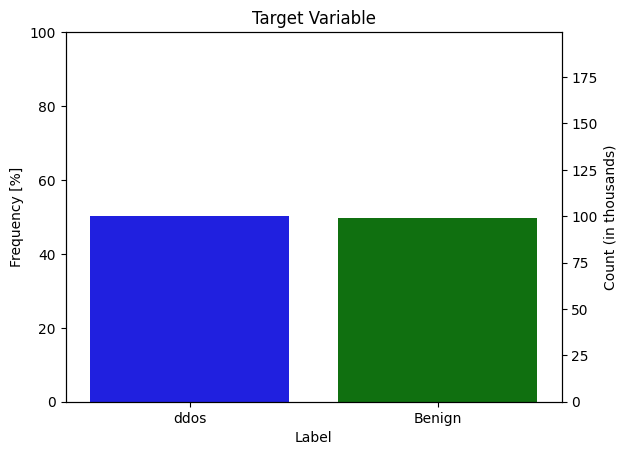

In [53]:
# First, convert the Spark DataFrame to a pandas DataFrame for visualization
pandas_df = df.toPandas()

# Plotting the target variable
label_count = pandas_df['Label'].value_counts(normalize=True) * 100
ax = sns.barplot(x=label_count.index, y=label_count.values, palette=['blue', 'green'])
ax1 = ax.twinx()
ax.set_ylabel('Frequency [%]')
ax1.set_ylabel("Count (in thousands)")
ax1.set_ylim(0, len(pandas_df) / 1000)
ax.set_ylim(0, 100)
plt.title('Target Variable')

# Show the plot

The dataset is almost balanced and contains the ratio of ddos sample over non-ddos samples is about 1:1

<Axes: xlabel='Protocol_Label', ylabel='Count'>

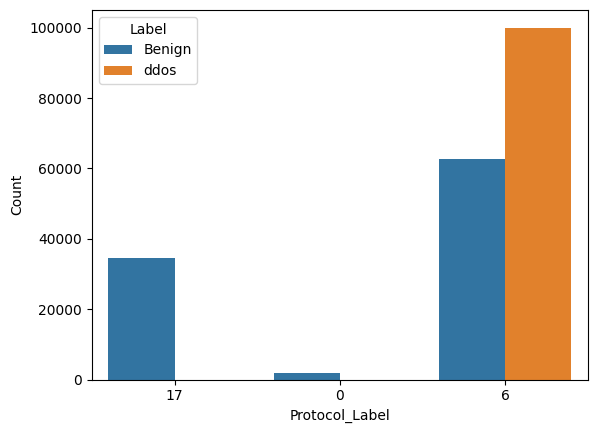

In [54]:
from pyspark.sql import functions as F
import seaborn as sns

# Crosstabulation using Spark
crosstab_df = df.crosstab('Protocol', 'Label')

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = crosstab_df.toPandas()

# Reshape the data to plot
pandas_df = pandas_df.melt(id_vars=['Protocol_Label'], var_name='Label', value_name='Count')

# Plotting the data
sns.barplot(x='Protocol_Label', y='Count', hue='Label', data=pandas_df)

protocal 6 and 17 are TCP and UDP respectively

we can see that the ddos sample in this dataset are all in protocal 6, which is TCP. So, the feature 'protocal' can be essential for detection

# Feature Engineering using Correlation values
examine the correlation values between each feature and the target variable (label) and select features with high absolute correlation values.

In [27]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt

In [28]:
# df = spark.read.csv("hdfs://172.31.8.146:9000/bal_min_200000.csv", schema=schema, header=True)
df = df_backup

In [29]:
df = df.withColumn("Label", when(df["Label"] == "ddos", 1).otherwise(0))

In [30]:
# feature_cols = df.columns[:-1]  # Exclude the label column
feature_cols = [col for col in df.columns if col not in ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]]

In [31]:
# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

In [32]:
# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
df = scaler.fit(df).transform(df)

In [33]:
# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df, "scaledFeatures").head()
correlation_array = correlation_matrix[0].toArray()

In [34]:
# Convert the correlation matrix to a DataFrame
corr_df = spark.createDataFrame(correlation_array.tolist(), feature_cols)

In [35]:
# Define the threshold for selecting features based on correlation
threshold_l = 0.1
threshold_r = 0.35

# Filter features based on correlation with the target variable (label)
selected_features = []
for feature in feature_cols:
    correlation_value = corr_df.select(feature).collect()[0][0]
    if abs(correlation_value) >= threshold_l and abs(correlation_value) <= threshold_r:
        selected_features.append(feature)

print("Selected Features:", selected_features)

Selected Features: ['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Std', 'Bwd IAT Max', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'RST Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Init Fwd Win Byts', 'Fwd Act Data Pkts', 'Idle Mean', 'Idle Max', 'Idle Min']


In [36]:
# drop the id column
selected_features = selected_features[1:]
selected_features

['Dst Port',
 'Protocol',
 'Flow Duration',
 'TotLen Fwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'RST Flag Cnt',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Bwd Seg Size Avg',
 'Subflow Fwd Byts',
 'Init Fwd Win Byts',
 'Fwd Act Data Pkts',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

In [39]:
len(selected_features)

38

In [37]:
# Extract correlation values for each feature with the target variable (label)
correlation_with_label = {}
for feature in feature_cols:
    correlation_value = corr_df.select(feature).collect()[0][0]
    correlation_with_label[feature] = correlation_value

# Print correlation values
for feature, correlation_value in correlation_with_label.items():
    print(f"Correlation of {feature} with Label: {correlation_value}")

Correlation of _c0 with Label: 1.0
Correlation of Src Port with Label: -0.2529874539862367
Correlation of Dst Port with Label: 0.2084628555358061
Correlation of Protocol with Label: 0.2709118267498474
Correlation of Flow Duration with Label: 0.21203340885039776
Correlation of Tot Fwd Pkts with Label: 0.0447760643979279
Correlation of Tot Bwd Pkts with Label: 0.019028339671772605
Correlation of TotLen Fwd Pkts with Label: 0.16623940648336222
Correlation of TotLen Bwd Pkts with Label: 0.011159725138251737
Correlation of Fwd Pkt Len Max with Label: 0.32680057197866025
Correlation of Fwd Pkt Len Min with Label: 0.2430294769832471
Correlation of Fwd Pkt Len Mean with Label: 0.39843847822895956
Correlation of Fwd Pkt Len Std with Label: 0.3096165461608137
Correlation of Bwd Pkt Len Max with Label: 0.33278635287489955
Correlation of Bwd Pkt Len Min with Label: 0.2837786371712582
Correlation of Bwd Pkt Len Mean with Label: 0.30785687505504383
Correlation of Bwd Pkt Len Std with Label: 0.299935

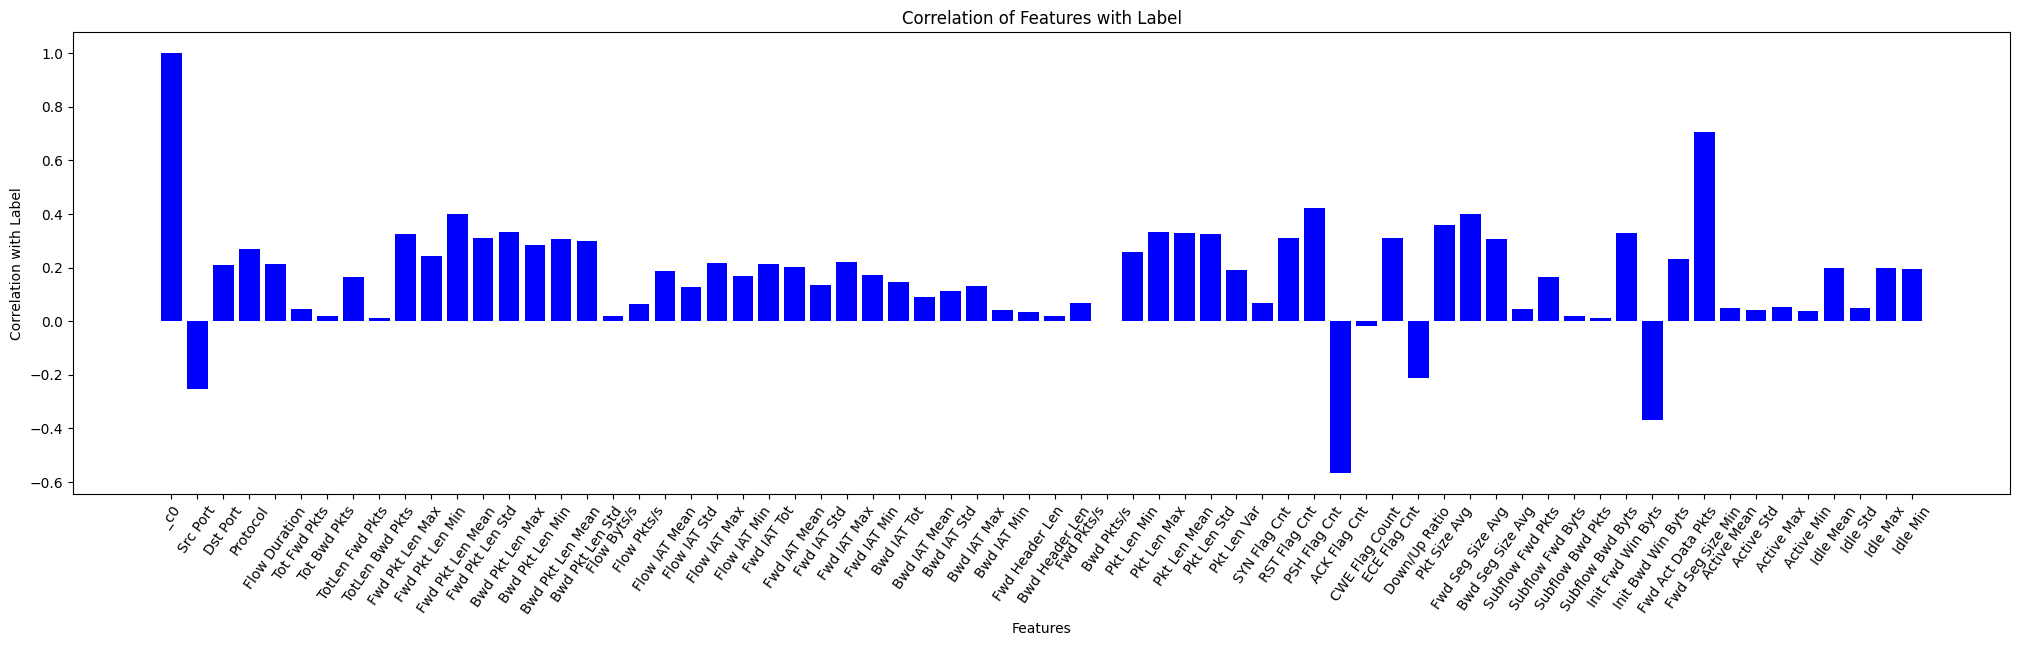

In [38]:
# Plot correlation values
plt.figure(figsize=(25, 6))
plt.bar(correlation_with_label.keys(), correlation_with_label.values(), color='blue')
plt.xlabel('Features')
plt.ylabel('Correlation with Label')
plt.title('Correlation of Features with Label')
plt.xticks(rotation=55)
plt.show()

## DDoS detection using random forest

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt

In [52]:
df = df_backup

In [228]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df = df.withColumn("Label", when(col("Label") == "ddos", 1).otherwise(0))

In [229]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])

In [62]:
testData.toPandas().describe()

,_c0,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,5.999300e+04,59993.000000,59993.000000,59993.000000,5.999300e+04,59993.000000,59993.000000,59993.000000,5.999300e+04,59993.000000,...,59993.000000,5.999300e+04,5.999300e+04,5.999300e+04,5.999300e+04,59993.0,5.999300e+04,59993.0,5.999300e+04,59993.000000
mean,2.209301e+06,49884.972997,3831.557198,7.839865,6.795272e+06,3.635007,4.089227,192.666992,2.714669e+03,92.775925,...,7.247312,1.433035e+05,6.995245e+04,2.116396e+05,9.599049e+04,2379992.0,9.424021e+04,2456473.0,2.293010e+06,0.502259
std,2.364950e+06,16337.761781,12959.388424,4.226739,2.444092e+07,51.872248,110.041848,810.512268,1.587419e+05,222.003296,...,8.913846,2.435227e+06,1.426363e+06,3.182056e+06,2.078318e+06,11044816.0,1.320865e+06,11273272.0,1.091365e+07,0.499999
min,2.300000e+02,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000
25%,4.811340e+05,50613.000000,80.000000,6.000000,1.259000e+03,1.000000,1.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000
50%,5.300720e+05,53386.000000,80.000000,6.000000,4.282000e+03,1.000000,1.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.000000
75%,3.931148e+06,57316.000000,443.000000,6.000000,3.054500e+04,2.000000,1.000000,46.000000,1.180000e+02,42.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.000000
max,7.902082e+06,65534.000000,65524.000000,17.000000,1.199998e+08,10105.000000,20861.000000,73848.000000,3.036578e+07,8460.000000,...,44.000000,1.057303e+08,5.370796e+07,1.057303e+08,1.057303e+08,119793752.0,6.416210e+07,119793752.0,1.197938e+08,1.000000


In [63]:
trainingData.toPandas().describe()

,_c0,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,1.392530e+05,139253.000000,139253.000000,139253.000000,1.392530e+05,139253.000000,139253.000000,139253.000000,1.392530e+05,139253.000000,...,139253.000000,1.392530e+05,1.392530e+05,1.392530e+05,1.392530e+05,139253.0,1.392530e+05,1.392530e+05,139253.0,139253.000000
mean,2.207732e+06,49822.437154,3888.119552,7.863184,6.732780e+06,3.430274,4.068099,191.649094,2.692497e+03,91.009521,...,7.259650,1.354125e+05,7.233598e+04,2.063319e+05,8.669095e+04,2328016.0,1.021090e+05,2.410580e+06,2234653.0,0.501734
std,2.360128e+06,16471.101622,13044.010407,4.236346,2.437341e+07,37.488134,114.602400,862.830566,1.660964e+05,217.384415,...,8.914777,2.329929e+06,1.445415e+06,3.125619e+06,1.941798e+06,10912551.0,1.403598e+06,1.116975e+07,10766366.0,0.499999
min,1.100000e+01,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000
25%,4.812560e+05,50630.000000,80.000000,6.000000,1.212000e+03,1.000000,1.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000
50%,5.305930e+05,53407.000000,80.000000,6.000000,4.207000e+03,1.000000,1.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.000000
75%,3.912459e+06,57357.000000,443.000000,6.000000,2.898600e+04,2.000000,1.000000,45.000000,1.130000e+02,42.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.000000
max,7.902428e+06,65534.000000,65534.000000,17.000000,1.199996e+08,10786.000000,21330.000000,114248.000000,3.112600e+07,6342.000000,...,44.000000,1.059147e+08,5.533398e+07,1.059147e+08,1.059147e+08,119933912.0,6.201602e+07,1.199339e+08,119933912.0,1.000000


In [64]:
testData.toPandas().head()

,_c0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,5985,192.168.10.5-23.208.99.33-49290-443-6,192.168.10.5,49290,23.208.99.33,443,6,03/07/2017 05:48:46 PM,38256708,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,8413,192.168.10.3-192.168.10.14-53-61922-17,192.168.10.14,61922,192.168.10.3,53,17,03/07/2017 05:51:18 PM,193,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,16028,192.168.10.25-52.84.145.208-49423-443-6,192.168.10.25,49423,52.84.145.208,443,6,03/07/2017 06:03:05 PM,108000,17,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,17322,192.168.10.19-69.165.222.176-123-123-17,192.168.10.19,123,69.165.222.176,123,17,03/07/2017 06:02:47 PM,66026605,1,...,0,27253.0,0.0,27253.0,27253.0,65972724.0,0.0,65972724.0,65972724.0,0
4,23114,173.194.175.156-192.168.10.15-443-49795-6,173.194.175.156,443,192.168.10.15,49795,6,03/07/2017 06:14:19 PM,3,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [65]:
trainingData.toPandas().head()

,_c0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,370,192.168.10.9-104.88.29.71-1077-443-6,192.168.10.9,1077,104.88.29.71,443,6,03/07/2017 05:32:02 PM,109701817,12,...,0,2115613.0,0.0,2115613.0,2115613.0,5472924.0,0.0,5472924.0,5472924.0,0
1,906,192.168.10.14-34.205.22.5-49664-443-6,192.168.10.14,49664,34.205.22.5,443,6,03/07/2017 05:36:40 PM,5560238,7,...,0,279458.0,0.0,279458.0,279458.0,5280777.0,0.0,5280777.0,5280777.0,0
2,934,162.208.22.39-192.168.10.14-443-49748-6,192.168.10.14,49748,162.208.22.39,443,6,03/07/2017 05:36:48 PM,114,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3541,192.168.10.14-23.50.75.27-50128-80-6,192.168.10.14,50128,23.50.75.27,80,6,03/07/2017 05:45:20 PM,5366214,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4174,192.168.10.16-72.167.239.239-42746-80-6,192.168.10.16,42746,72.167.239.239,80,6,03/07/2017 05:46:10 PM,91307,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [66]:
trainingData.toPandas().tail()

,_c0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
139248,7880494,172.31.67.93-200.57.131.236-3389-63148-6,200.57.131.236,63148,172.31.67.93,3389,6,20/02/2018 12:05:19,2755287,9,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
139249,7885684,172.31.67.95-66.212.179.70-3389-50497-6,66.212.179.70,50497,172.31.67.95,3389,6,20/02/2018 04:08:02,3963842,11,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
139250,7886428,172.31.67.95-211.170.54.2-3389-53584-6,211.170.54.2,53584,172.31.67.95,3389,6,20/02/2018 11:23:31,2208490,8,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
139251,7895527,172.31.69.15-202.21.112.4-445-1321-6,202.21.112.4,1321,172.31.69.15,445,6,20/02/2018 12:11:36,1451226,3,...,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
139252,7897801,172.31.69.21-181.214.87.12-20207-51313-6,181.214.87.12,51313,172.31.69.21,20207,6,20/02/2018 10:58:07,146870,2,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [67]:
testData.toPandas().tail()

,_c0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
59988,7765586,172.31.67.34-211.170.54.2-3389-57777-6,211.170.54.2,57777,172.31.67.34,3389,6,20/02/2018 12:23:23,2330131,8,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
59989,7766327,160.202.159.194-172.31.67.34-59256-3389-6,160.202.159.194,59256,172.31.67.34,3389,6,20/02/2018 12:29:20,2362391,9,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
59990,7773076,172.31.0.2-172.31.67.40-53-64884-17,172.31.67.40,64884,172.31.0.2,53,17,20/02/2018 02:41:18,27455,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
59991,7865113,172.31.67.89-5.39.216.195-3389-39341-6,172.31.67.89,3389,5.39.216.195,39341,6,20/02/2018 03:04:49,88454992,2,...,20,0.0,0.0,0.0,0.0,88454992.0,0.0,88454992.0,88454992.0,0
59992,7898621,172.31.69.22-221.194.47.243-22-57812-6,221.194.47.243,57812,172.31.69.22,22,6,20/02/2018 04:49:41,3170537,10,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [230]:
# do not use some features for training
# selected_cols = [col for col in df.columns if col not in ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]]
# selected_cols = [col for col in df.columns if col in ["Flow Pkts/s", "Bwd Pkts/s",
#                                                      'Tot Fwd Pkts',
#                                                      'Tot Bwd Pkts']
selected_cols = [col for col in df.columns if col in selected_features]

# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

In [231]:
%%time

rf = RandomForestClassifier(labelCol="Label", featuresCol="features", numTrees=10)
pipeline = Pipeline(stages=[assembler, rf])

model = pipeline.fit(trainingData)

CPU times: user 40.1 ms, sys: 370 µs, total: 40.5 ms
Wall time: 6.64 s


In [232]:
%%time
predictions = model.transform(testData)

CPU times: user 16.3 ms, sys: 238 µs, total: 16.6 ms
Wall time: 287 ms


In [236]:
predictions.toPandas().head()

,_c0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,features,rawPrediction,probability,prediction
0,16028,192.168.10.25-52.84.145.208-49423-443-6,192.168.10.25,49423,52.84.145.208,443,6,03/07/2017 06:03:05 PM,108000,17,...,0.0,0.0,0.000000e+00,0.0,0.0,0,"[49.05882263183594, 0.0, 0.0, 662.444458007812...","[9.967954290573122, 0.03204570942687831]","[0.9967954290573122, 0.003204570942687831]",0.0
1,22827,192.168.10.1-192.168.10.3-53-62485-17,192.168.10.3,62485,192.168.10.1,53,17,03/07/2017 05:59:23 PM,509,0,...,0.0,0.0,0.000000e+00,0.0,0.0,0,"(0.0, 0.0, 0.0, 105.5, 0.0, -1.0, 0.0)","[9.996271205808076, 0.0037287941919244023]","[0.9996271205808075, 0.00037287941919244015]",0.0
2,23107,172.217.11.6-192.168.10.51-443-49010-6,192.168.10.51,49010,172.217.11.6,443,6,03/07/2017 06:12:22 PM,116439613,63,...,36648.0,9607746.0,1.379302e+06,10011266.0,5228123.0,0,"[32.19047546386719, 0.0, 0.0, 763.740478515625...","[9.967954290573122, 0.03204570942687831]","[0.9967954290573122, 0.003204570942687831]",0.0
3,30014,184.31.6.135-192.168.10.9-443-63616-6,192.168.10.9,63616,184.31.6.135,443,6,03/07/2017 06:18:31 PM,117069975,23,...,28486.0,9983783.0,8.618276e+04,10086934.0,9736499.0,0,"[106.73912811279297, 0.0, 0.0, 106.06666564941...","[9.967954290573122, 0.03204570942687831]","[0.9967954290573122, 0.003204570942687831]",0.0
4,38315,192.168.10.5-74.217.250.92-52386-443-6,192.168.10.5,52386,74.217.250.92,443,6,03/07/2017 06:29:34 PM,7785642,1,...,0.0,0.0,0.000000e+00,0.0,0.0,0,"(0.0, 0.0, 1.0, 0.0, 0.0, 255.0, 0.0)","[8.049898259709716, 1.9501017402902852]","[0.8049898259709716, 0.1950101740290285]",0.0


In [241]:
%%time
evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="rawPrediction")
roc = evaluator.evaluate(predictions)
print("ROC = %g" % (roc))

ROC = 0.999958
CPU times: user 1.44 ms, sys: 7.3 ms, total: 8.74 ms
Wall time: 1.6 s


In [242]:
# more evaluations
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a multiclass classification evaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "precisionByLabel"})

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "recallByLabel"})

# Calculate F1 score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("ROC: ", roc)

Accuracy:  0.9992990186260765
Precision:  0.9986598767086572
Recall:  0.9999329084199933
F1 Score:  0.9992990205404744
ROC:  0.9999575022775948


Vitialize to compare the training time on single-node machine and 2-node spark cluster

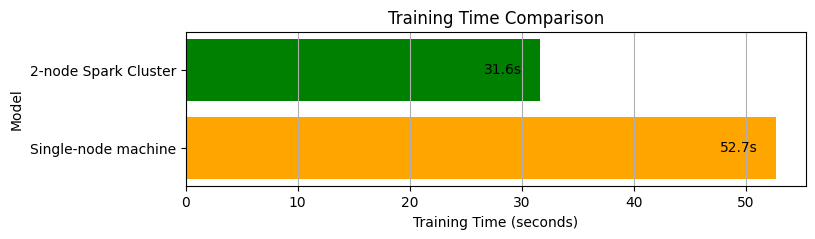

In [35]:
# Data
models = ['Single-node machine', '2-node Spark Cluster']
training_times = [52.7, 31.6]  # Replace with your actual training times in seconds

# Plot
plt.figure(figsize=(8, 2))
bars = plt.barh(models, training_times, color=['orange', 'green'])

# Add value on top of each bar
for bar in bars:
    plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width()}s', va='center')

plt.xlabel('Training Time (seconds)')
plt.ylabel('Model')
plt.title('Training Time Comparison')
plt.grid(axis='x')
plt.show()

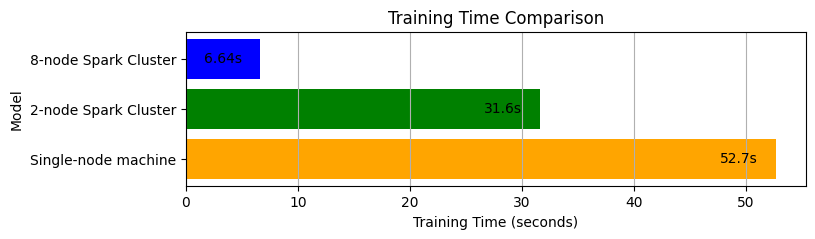

In [235]:
# Data
models = ['Single-node machine', '2-node Spark Cluster', '8-node Spark Cluster']
training_times = [52.7, 31.6, 6.64]  # Replace with your actual training times in seconds

# Plot
plt.figure(figsize=(8, 2))
bars = plt.barh(models, training_times, color=['orange', 'green', 'blue'])

# Add value on top of each bar
for bar in bars:
    plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width()}s', va='center')

plt.xlabel('Training Time (seconds)')
plt.ylabel('Model')
plt.title('Training Time Comparison')
plt.grid(axis='x')
plt.show()

## Withou pipeline

In [27]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
df = df.withColumn("Label", when(col("Label") == "ddos", 1).otherwise(0))

In [28]:
# Split the data into training and test sets
(trainingData, testData) = df.randomSplit([0.7, 0.3])

In [45]:
# Select features
# selected_cols = [col for col in df.columns if col not in ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]]
# selected_cols = [col for col in df.columns if col in ["Flow Pkts/s"]]
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

In [46]:
selected_cols

['_c0',
 'Src Port',
 'Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Subflow Fwd Pkts',
 'Subflow Fwd Byts',
 'Subflow Bwd Pkts',
 'Subflow Bwd Byts',
 'Init Fwd Win Byts',


In [39]:
# Transform the training data
trainingData_transformed = assembler.transform(trainingData)

In [40]:
# Define Random Forest classifier
rf = RandomForestClassifier(labelCol="Label", featuresCol="features", numTrees=10)

In [41]:
# Fit the model
model = rf.fit(trainingData_transformed)

In [42]:
# Transform the test data
testData_transformed = assembler.transform(testData)

In [43]:
# Make predictions
predictions = model.transform(testData_transformed)

In [44]:
# Evaluate model performance
evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))

Test Accuracy = 0.872858


# New version for solving potential overfitting

In [44]:
df = df_backup

In [54]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df = df.withColumn("Label", when(col("Label") == "ddos", 1).otherwise(0))

In [55]:
selected_cols = [col for col in df.columns if col in selected_features]

# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

### Perform data preprocessing using scaler
Feature scaling (also known as data normalization or standardization) is a preprocessing step that transforms the features (columns) of a dataset to have similar scales or ranges.

The purpose of feature scaling here is to ensure that all features contribute equally to our model training process, preventing features with larger scales from dominating those with smaller scales. It also helps the algorithms converge faster and may improve the performance of certain machine learning algorithms, particularly those that rely on distance metrics or gradient descent optimization.

In [56]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

### Use PCA for feature selection to reduce the number of features

In [57]:
# reduce to 3 principal components
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")

### Define a new Random Forest model

In [58]:
rf = RandomForestClassifier(labelCol="Label", featuresCol="pcaFeatures")
pipeline = Pipeline(stages=[assembler, scaler, pca, rf])

### Add the process of hyperparameter tunning
This usually works together with the k-fold cross validation

In [59]:
# Define hyperparameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

### Try k-fold cross validation (10-fold)

In [60]:
# use ROC index for evaluation
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")
# 10-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)  

In [61]:
%%time
cvModel = crossval.fit(df)

CPU times: user 7.31 s, sys: 1.95 s, total: 9.25 s
Wall time: 9min 31s


In [63]:
# store the trained model
model_path = "models/trained_on_bal_200000"
cvModel.save(model_path)

In [62]:
%%time
# Make predictions
predictions = cvModel.transform(df)

CPU times: user 9.87 ms, sys: 3.43 ms, total: 13.3 ms
Wall time: 84 ms


In [74]:
# Evaluate model performance
roc = evaluator.evaluate(predictions)
roc

0.9999935525865022

In [75]:
# more evaluations

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a multiclass classification evaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "precisionByLabel"})

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "recallByLabel"})

# Calculate F1 score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("ROC: ", roc)

Accuracy:  0.9994278429679894
Precision:  0.9988626985245275
Recall:  0.9999899240271648
F1 Score:  0.9994278440043086
ROC:  0.9999935525865022


In [76]:
# get the hyperparameter combination of the best model
best_model = cvModel.bestModel

In [77]:
# Extract the parameter values from the best model
best_num_trees = best_model.stages[-1].getNumTrees
best_max_depth = best_model.stages[-1].getOrDefault('maxDepth')

# Print the best hyperparameter combination
print("Best Num Trees:", best_num_trees)
print("Best Max Depth:", best_max_depth)

Best Num Trees: 100
Best Max Depth: 10


In [1]:
# Define the evaluation metrics and their values
# metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC']
# values = [accuracy, precision, recall, f1_score, roc]

# # Plot the evaluation metrics
# plt.figure(figsize=(10, 6))
# plt.bar(metrics, values, color='blue')
# plt.xlabel('Evaluation Metric')
# plt.ylabel('Value')
# plt.title('Model Evaluation Metrics')
# plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
# plt.show()

Vitualize to compare the training time with different cluster structure

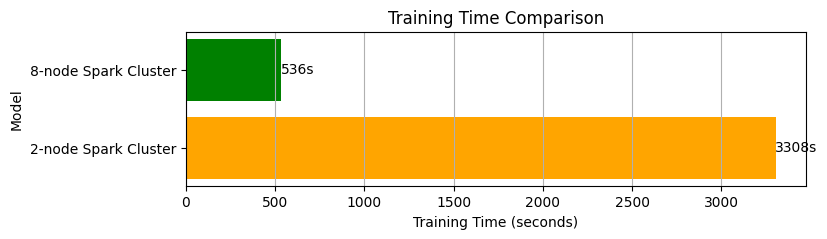

In [225]:
# Data
models = ['2-node Spark Cluster', '8-node Spark Cluster']
training_times = [3308, 536]  # Replace with your actual training times in seconds

# Plot
plt.figure(figsize=(8, 2))
bars = plt.barh(models, training_times, color=['orange', 'green'])

# Add value on top of each bar
for bar in bars:
    plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width()}s', va='center')

plt.xlabel('Training Time (seconds)')
plt.ylabel('Model')
plt.title('Training Time Comparison')
plt.grid(axis='x')
plt.show()

## Cross-Validation upon Train-test split

In [11]:
# for test
selected_features = ['Fwd Pkt Len Mean',
                     'PSH Flag Cnt',
                     'ACK Flag Cnt',
                     'Pkt Size Avg',
                     'Fwd Seg Size Avg',
                     'Init Bwd Win Byts',
                     'Fwd Seg Size Min']

In [28]:
df = df_backup

In [13]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df = df.withColumn("Label", when(col("Label") == "ddos", 1).otherwise(0))

In [14]:
selected_cols = [col for col in df.columns if col in selected_features]

# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

In [15]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [16]:
# reduce to 3 principal components
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")

In [17]:
rf = RandomForestClassifier(labelCol="Label", featuresCol="pcaFeatures")
pipeline = Pipeline(stages=[assembler, scaler, pca, rf])

In [18]:
# Define hyperparameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

In [19]:
# use ROC index for evaluation
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")
# 10-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)  

In [22]:
# check distinct label values
distinct_labels = df.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

1
0


In [23]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])

In [24]:
%%time
cvModel = crossval.fit(trainingData)

24/04/25 23:52:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


24/04/25 23:52:51 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/04/25 23:52:51 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


CPU times: user 8.17 s, sys: 1.92 s, total: 10.1 s
Wall time: 9min 45s


In [25]:
%%time
# Make predictions
predictions = cvModel.transform(testData)

CPU times: user 8.81 ms, sys: 7.39 ms, total: 16.2 ms
Wall time: 240 ms


In [26]:
# Evaluate model performance
roc = evaluator.evaluate(predictions)
roc

0.9999816235741953

In [27]:
# more evaluations

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a multiclass classification evaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "precisionByLabel"})

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "recallByLabel"})

# Calculate F1 score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("ROC: ", roc)

Accuracy:  0.9993834771886559
Precision:  0.9988012387199894
Recall:  0.9999666622216296
F1 Score:  0.9993834771107706
ROC:  0.9999816235741953


In [34]:
# get the hyperparameter combination of the best model
best_model = cvModel.bestModel
# Extract the parameter values from the best model
best_num_trees = best_model.stages[-1].getNumTrees
best_max_depth = best_model.stages[-1].getOrDefault('maxDepth')

# Print the best hyperparameter combination
print("Best Num Trees:", best_num_trees)
print("Best Max Depth:", best_max_depth)

Best Num Trees: 100
Best Max Depth: 10


## RF on 022118 imbalanced dataset

In [79]:
df = (spark.read
         .format("csv")
         .option("inferSchema", True)
         .option("header", True)
         .load("hdfs://172.31.8.146:9000/02-21-2018.csv"))

In [80]:
from pyspark.sql.functions import col, when
#drop unused columns, drop Nan values, convert string labels to integer
df = df.drop('Timestamp')
df = df.na.drop()
df = df.withColumn("Label", when(col("Label") == "Benign", 1).otherwise(0))

In [81]:
#separate features and label columns
features = df.columns[:-1]
label = df.columns[-1]

In [82]:
pca_50 = PCA(k=30, inputCol="features", outputCol="pca50Features")  # Reduce to 50 principal components

In [83]:
# Assemble the features into a single vector (necessary for Spark MLlib models)
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(df)

model = pca_50.fit(data)
data = model.transform(data)

# Select the features vector and the label column
data = data.select("pca50Features", label)
# Split the data into training and test sets
trainData, testData = data.randomSplit([0.7, 0.3])

In [84]:
# Create the Random Forest classifier
rf = RandomForestClassifier(featuresCol="pca50Features", labelCol=label,
                             numTrees=100, maxDepth=5, minInstancesPerNode=10,
                             subsamplingRate=0.8, featureSubsetStrategy="sqrt")

In [85]:
%%time
# Fit the model to the training data
rf_model = rf.fit(trainData)

CPU times: user 61.4 ms, sys: 11.6 ms, total: 73 ms
Wall time: 32.1 s


In [86]:
# Make predictions on the test data
predictions = rf_model.transform(testData)

In [87]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Label")
accuracy = evaluator.evaluate(predictions)

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",
    predictionCol="prediction",
    metricName="precisionByLabel")

# You can specify the label here if you have multiple classes and you are interested in one specific class
precision = precision_evaluator.evaluate(predictions)

# Evaluator for recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",
    predictionCol="prediction",
    metricName="recallByLabel")

# As with precision, specify the label for recall calculation if needed
recall = recall_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.999999997245115
Precision: 0.9999419395106468
Recall: 0.9999903227835545


# Learning Curve - training ratio
Comparing the model performance with different values of **training ratio** on the training and validation set

In [19]:
df = (spark.read
         .format("csv")
         .option("inferSchema", True)
         .option("header", True)
         .load("hdfs://172.31.8.146:9000/02-21-2018.csv"))

In [20]:
from pyspark.sql.functions import col, when
#drop unused columns, drop Nan values, convert string labels to integer
df = df.drop('Timestamp')
df = df.na.drop()
df = df.withColumn("Label", when(col("Label") == "Benign", 1).otherwise(0))

In [21]:
#separate features and label columns
features = df.columns[:-1]
label = df.columns[-1]

In [22]:
pca_50 = PCA(k=10, inputCol="features", outputCol="pca50Features")  # Reduce to 10 principal components

In [23]:
# Assemble the features into a single vector (necessary for Spark MLlib models)
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(df)

model = pca_50.fit(data)
data = model.transform(data)

# Select the features vector and the label column
data = data.select("pca50Features", label)

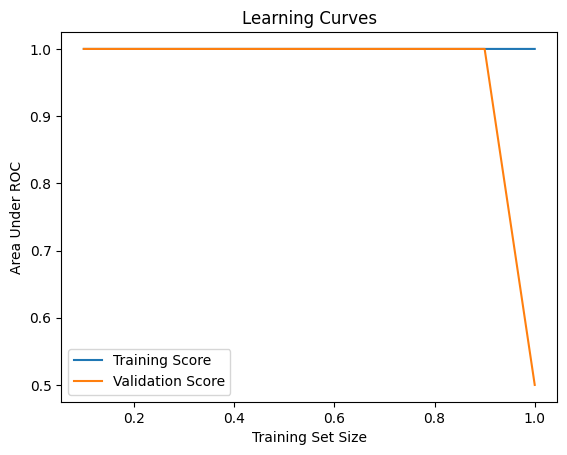

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of training dataset sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Initialize lists to store training and validation performance
train_scores = []
val_scores = []

# Loop over different training dataset sizes
for size in train_sizes:
    # Split the data into training and validation sets
    trainData, valData = data.randomSplit([size, 1.0 - size], seed=42)
    
    # Create and train the RandomForestClassifier
    rf = RandomForestClassifier(featuresCol="pca50Features", labelCol=label)
    model = rf.fit(trainData)
    
    # Make predictions on the training and validation data
    train_preds = model.transform(trainData)
    val_preds = model.transform(valData)
    
    # Evaluate the model's performance on training and validation data
    evaluator = BinaryClassificationEvaluator(labelCol=label)
    train_score = evaluator.evaluate(train_preds)
    val_score = evaluator.evaluate(val_preds)
    
    # Append scores to lists
    train_scores.append(train_score)
    val_scores.append(val_score)

# Plot learning curves
plt.plot(train_sizes, train_scores, label='Training Score')
plt.plot(train_sizes, val_scores, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Area Under ROC')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [9]:
selected_features = [
     'Dst Port',
     'Protocol',
     'Flow Duration',
     'TotLen Fwd Pkts',
     'Fwd Pkt Len Max',
     'Fwd Pkt Len Min',
     'Fwd Pkt Len Std',
     'Bwd Pkt Len Max',
     'Bwd Pkt Len Min',
     'Bwd Pkt Len Mean',
     'Bwd Pkt Len Std',
     'Flow IAT Mean',
     'Flow IAT Std',
     'Flow IAT Max',
     'Flow IAT Min',
     'Fwd IAT Tot',
     'Fwd IAT Mean',
     'Fwd IAT Std',
     'Fwd IAT Max',
     'Fwd IAT Min',
     'Bwd IAT Tot',
     'Bwd IAT Std',
     'Bwd IAT Max',
     'Pkt Len Min',
     'Pkt Len Max',
     'Pkt Len Mean',
     'Pkt Len Std',
     'Pkt Len Var',
     'RST Flag Cnt',
     'ECE Flag Cnt',
     'Down/Up Ratio',
     'Bwd Seg Size Avg',
     'Subflow Fwd Byts',
     'Init Fwd Win Byts',
     'Fwd Act Data Pkts',
     'Idle Mean',
     'Idle Max',
     'Idle Min'
]

# Learning Curve - numTrees
Comparing the model performance with different values of **numTrees** on the training and validation set

In [18]:
df = spark.read.csv("hdfs://172.31.8.146:9000/bal_min_200000.csv", schema=schema, header=True)

In [19]:
df = df.withColumn("Label", when(df["Label"] == "ddos", 1).otherwise(0))

In [20]:
selected_cols = [col for col in df.columns if col in selected_features]
# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

In [21]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [22]:
pca = PCA(k=10, inputCol="scaledFeatures", outputCol="pcaFeatures")

epoch of numTree=10 finished


epoch of numTree=30 finished


epoch of numTree=50 finished


epoch of numTree=70 finished


epoch of numTree=100 finished


epoch of numTree=150 finished


epoch of numTree=200 finished


epoch of numTree=250 finished


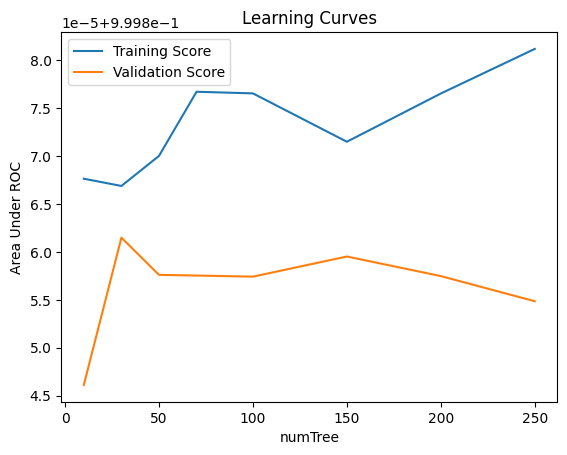

In [31]:
# Initialize lists to store training and validation performance
train_scores = []
val_scores = []

numTree_vals = [10, 30, 50, 70, 100, 150, 200, 250]

# Loop over different training dataset sizes
for numTree in numTree_vals:
    
    # Split the data into training and validation sets
    train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

    # create the RF model and the pipeline with this numTree value
    rf = RandomForestClassifier(labelCol="Label", featuresCol="pcaFeatures", numTrees=numTree)
    pipeline = Pipeline(stages=[assembler, scaler, pca, rf])

    # Fit the pipeline to training set
    model = pipeline.fit(train_data)

    
    # Make predictions on the training and validation data
    train_preds = model.transform(train_data)
    val_preds = model.transform(test_data)
    
    # Evaluate the model's performance on training and validation data
    evaluator = BinaryClassificationEvaluator(labelCol='Label')
    train_score = evaluator.evaluate(train_preds)
    val_score = evaluator.evaluate(val_preds)
    
    # Append scores to lists
    train_scores.append(train_score)
    val_scores.append(val_score)

    print("====================================")
    print("epoch of numTree={} finished".format(numTree))

# Plot learning curves
plt.plot(numTree_vals, train_scores, label='Training Score')
plt.plot(numTree_vals, val_scores, label='Validation Score')
plt.xlabel('numTree')
plt.ylabel('Area Under ROC')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [24]:
# # Define hyperparameter grid for tuning
# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [10, 50, 100]) \
#     .addGrid(rf.maxDepth, [5, 10, 15]) \
#     .build()

# Learning Curve - maxDepth
Comparing the model performance with different values of **maxDepth** on the training and validation set

In [32]:
df = spark.read.csv("hdfs://172.31.8.146:9000/bal_min_200000.csv", schema=schema, header=True)

In [33]:
df = df.withColumn("Label", when(df["Label"] == "ddos", 1).otherwise(0))

In [34]:
selected_cols = [col for col in df.columns if col in selected_features]
# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

In [35]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [36]:
pca = PCA(k=10, inputCol="scaledFeatures", outputCol="pcaFeatures")

epoch of numTree=250 finished


epoch of numTree=250 finished


epoch of numTree=250 finished


epoch of numTree=250 finished


epoch of numTree=250 finished


epoch of numTree=250 finished


epoch of numTree=250 finished


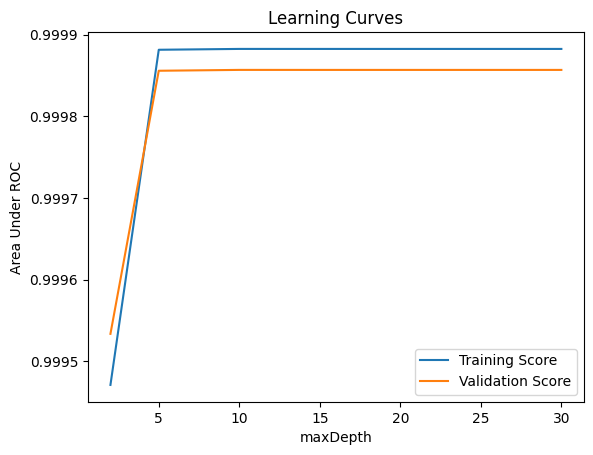

In [37]:
# Initialize lists to store training and validation performance
train_scores = []
val_scores = []

maxDepth_vals = [2, 5, 10, 15, 20, 25, 30]

# Loop over different maxDepth values
for maxDepth in maxDepth_vals:
    
    # Split the data into training and validation sets
    train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

    # create the RF model and the pipeline with this numTree value
    rf = RandomForestClassifier(labelCol="Label", featuresCol="pcaFeatures", maxDepth=maxDepth)
    pipeline = Pipeline(stages=[assembler, scaler, pca, rf])

    # Fit the pipeline to training set
    model = pipeline.fit(train_data)
    
    # Make predictions on the training and validation data
    train_preds = model.transform(train_data)
    val_preds = model.transform(test_data)
    
    # Evaluate the model's performance on training and validation data
    evaluator = BinaryClassificationEvaluator(labelCol='Label')
    train_score = evaluator.evaluate(train_preds)
    val_score = evaluator.evaluate(val_preds)
    
    # Append scores to lists
    train_scores.append(train_score)
    val_scores.append(val_score)

    print("====================================")
    print("epoch of numTree={} finished".format(numTree))

# Plot learning curves
plt.plot(maxDepth_vals, train_scores, label='Training Score')
plt.plot(maxDepth_vals, val_scores, label='Validation Score')
plt.xlabel('maxDepth')
plt.ylabel('Area Under ROC')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [38]:
spark.stop()

# RF on 200000 rows balanced dataset
## with cross-validation on training set, and validation on testing set

In [37]:
df = spark.read.csv("hdfs://172.31.8.146:9000/bal_min_200000.csv", schema=schema, header=True)

In [38]:
df = df.drop('Timestamp')
df = df.drop('Flow ID')
df = df.drop('Src IP')
df = df.drop('Dst IP')
df = df.drop('_c0')
df = df.na.drop()

In [39]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df = df.withColumn("Label", when(col("Label") == "ddos", 1).otherwise(0))

In [40]:
selected_features = [
     'Dst Port',
     'Protocol',
     'Flow Duration',
     'TotLen Fwd Pkts',
     'Fwd Pkt Len Max',
     'Fwd Pkt Len Min',
     'Fwd Pkt Len Std',
     'Bwd Pkt Len Max',
     'Bwd Pkt Len Min',
     'Bwd Pkt Len Mean',
     'Bwd Pkt Len Std',
     'Flow IAT Mean',
     'Flow IAT Std',
     'Flow IAT Max',
     'Flow IAT Min',
     'Fwd IAT Tot',
     'Fwd IAT Mean',
     'Fwd IAT Std',
     'Fwd IAT Max',
     'Fwd IAT Min',
     'Bwd IAT Tot',
     'Bwd IAT Std',
     'Bwd IAT Max',
     'Pkt Len Min',
     'Pkt Len Max',
     'Pkt Len Mean',
     'Pkt Len Std',
     'Pkt Len Var',
     'RST Flag Cnt',
     'ECE Flag Cnt',
     'Down/Up Ratio',
     'Bwd Seg Size Avg',
     'Subflow Fwd Byts',
     'Init Fwd Win Byts',
     'Fwd Act Data Pkts',
     'Idle Mean',
     'Idle Max',
     'Idle Min'
]

In [41]:
selected_cols = [col for col in df.columns if col in selected_features]

# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

### Perform data preprocessing using scaler
Feature scaling (also known as data normalization or standardization) is a preprocessing step that transforms the features (columns) of a dataset to have similar scales or ranges.

The purpose of feature scaling here is to ensure that all features contribute equally to our model training process, preventing features with larger scales from dominating those with smaller scales. It also helps the algorithms converge faster and may improve the performance of certain machine learning algorithms, particularly those that rely on distance metrics or gradient descent optimization.

In [42]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

### Use PCA for feature selection to reduce the number of features

In [43]:
# reduce to 30 principal components
pca = PCA(k=1, inputCol="scaledFeatures", outputCol="pcaFeatures")

### Define a new Random Forest model

In [44]:
rf = RandomForestClassifier(labelCol="Label", featuresCol="pcaFeatures")
pipeline = Pipeline(stages=[assembler, scaler, pca, rf])

### Add the process of hyperparameter tunning
This usually works together with the k-fold cross validation

In [45]:
# Define hyperparameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

### Try k-fold cross validation (10-fold)

In [46]:
# use ROC index for evaluation
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")
# 10-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)  

### Split df into training and validation set

In [47]:
# Split the data into training and test sets
(df_train, df_test) = df.randomSplit([0.7, 0.3])

In [48]:
%%time
cvModel = crossval.fit(df_train)

CPU times: user 8.33 s, sys: 2.14 s, total: 10.5 s
Wall time: 9min 24s


In [49]:
%%time
# Make predictions on training set
predictions_train = cvModel.transform(df_train)

CPU times: user 14.7 ms, sys: 2.49 ms, total: 17.2 ms
Wall time: 107 ms


In [50]:
%%time
# Make predictions on validation set
predictions_test = cvModel.transform(df_test)

CPU times: user 8.23 ms, sys: 9.1 ms, total: 17.3 ms
Wall time: 180 ms


In [51]:
# Evaluate the performance on the training set
roc_train = evaluator.evaluate(predictions_train)
roc_train

0.9839316971778981

In [52]:
# Evaluate the performance on the validation set
roc_test = evaluator.evaluate(predictions_test)
roc_test

0.98442601230846

In [53]:
# more evaluations

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a multiclass classification evaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions_test, {multiclass_evaluator.metricName: "accuracy"})

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions_test, {multiclass_evaluator.metricName: "precisionByLabel"})

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions_test, {multiclass_evaluator.metricName: "recallByLabel"})

# Calculate F1 score
f1_score = multiclass_evaluator.evaluate(predictions_test, {multiclass_evaluator.metricName: "f1"})

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("ROC: ", roc_test)

Accuracy:  0.983871236760904
Precision:  0.9824561403508771
Recall:  0.9852493561226879
F1 Score:  0.9838712657465823
ROC:  0.98442601230846


In [54]:
# Calculate accuracy
accuracy_train = multiclass_evaluator.evaluate(predictions_train, {multiclass_evaluator.metricName: "accuracy"})

# Calculate precision
precision_train = multiclass_evaluator.evaluate(predictions_train, {multiclass_evaluator.metricName: "precisionByLabel"})

# Calculate recall
recall_train = multiclass_evaluator.evaluate(predictions_train, {multiclass_evaluator.metricName: "recallByLabel"})

# Calculate F1 score
f1_score_train = multiclass_evaluator.evaluate(predictions_train, {multiclass_evaluator.metricName: "f1"})

# Print the evaluation metrics
print("Accuracy: ", accuracy_train)
print("Precision: ", precision_train)
print("Recall: ", recall_train)
print("F1 Score: ", f1_score_train)
print("ROC: ", roc_train)

Accuracy:  0.9833493344032557
Precision:  0.9813765877102644
Recall:  0.9853228400735294
F1 Score:  0.9833493415828822
ROC:  0.9839316971778981


In [56]:
spark.stop()